# Tiền xử lý

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Đọc dataset từ file CSV
df = pd.read_csv("traffic_accidents.csv")


# Xóa cột "crash_date" nếu tồn tại
if "crash_date" in df.columns:
    df = df.drop(columns=["crash_date"])

# Các cột cần mã hóa
categorical_columns = [
    "traffic_control_device", "weather_condition", "lighting_condition", "first_crash_type",
    "trafficway_type", "alignment", "roadway_surface_cond", "road_defect", "crash_type",
    "intersection_related_i", "damage", "prim_contributory_cause", "most_severe_injury"
]

# In ra tên các cột trong DataFrame để kiểm tra
print(df.columns)

# Dictionary để lưu các label encoder
decoders = {}

# Mã hóa từng cột
for col in categorical_columns:
    # Kiểm tra xem cột có tồn tại trong DataFrame không
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])  # Thay đổi trực tiếp giá trị trong cột
        decoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))  # Lưu mapping cho báo cáo
    else:
        print(f"Cột '{col}' không tồn tại trong DataFrame.")

# Xuất báo cáo mã hóa
encoding_report = """Báo cáo Mã hóa Categorical Data\n\n"""
for col, mapping in decoders.items():
    encoding_report += f"Cột: {col}\n"
    for key, value in mapping.items():
        encoding_report += f"  {key}: {value}\n"
    encoding_report += "\n"

# Xuất báo cáo mã hoá ra file
with open("encoding_report.txt", "w", encoding="utf-8") as f:
    f.write(encoding_report)

# Lưu dataset đã mã hóa
encoded_file = "encoded_dataset.csv"
df.to_csv(encoded_file, index=False)

print(f"Mã hóa hoàn tất! Dataset đã lưu vào: {encoded_file}")
print(f"Báo cáo mã hóa đã lưu vào: encoding_report.txt")

Index(['traffic_control_device', 'weather_condition', 'lighting_condition',
       'first_crash_type', 'trafficway_type', 'alignment',
       'roadway_surface_cond', 'road_defect', 'crash_type',
       'intersection_related_i', 'damage', 'prim_contributory_cause',
       'num_units', 'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication', 'crash_hour',
       'crash_day_of_week', 'crash_month'],
      dtype='object')
Mã hóa hoàn tất! Dataset đã lưu vào: encoded_dataset.csv
Báo cáo mã hóa đã lưu vào: encoding_report.txt


In [3]:
# Thông tin tổng quan về dataset sau xử lý
print("Dataset Shape:", df.shape)

Dataset Shape: (209306, 23)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   traffic_control_device         209306 non-null  int64  
 1   weather_condition              209306 non-null  int64  
 2   lighting_condition             209306 non-null  int64  
 3   first_crash_type               209306 non-null  int64  
 4   trafficway_type                209306 non-null  int64  
 5   alignment                      209306 non-null  int64  
 6   roadway_surface_cond           209306 non-null  int64  
 7   road_defect                    209306 non-null  int64  
 8   crash_type                     209306 non-null  int64  
 9   intersection_related_i         209306 non-null  int64  
 10  damage                         209306 non-null  int64  
 11  prim_contributory_cause        209306 non-null  int64  
 12  num_units                     

In [5]:
df.isnull().sum()

,0
traffic_control_device,0
weather_condition,0
lighting_condition,0
first_crash_type,0
trafficway_type,0
alignment,0
roadway_surface_cond,0
road_defect,0
crash_type,0
intersection_related_i,0


In [6]:
df.describe()

,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
count,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,...,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000
mean,14.022274,3.131353,2.437221,9.746668,6.885861,3.010946,1.371695,1.697701,0.560787,0.952309,...,2.269514,0.382717,0.001859,0.038102,0.221241,0.121516,2.244002,13.373047,4.144024,6.771822
std,4.174489,2.476463,1.074239,6.700632,3.553885,0.192001,2.400657,1.516204,0.496292,0.213112,...,0.650588,0.799720,0.047502,0.233964,0.614960,0.450865,1.241175,5.603830,1.966864,3.427593
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,15.000000,2.000000,1.000000,1.250000,6.000000,3.000000,0.000000,1.000000,0.000000,1.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,2.000000,4.000000
50%,16.000000,2.000000,3.000000,10.000000,8.000000,3.000000,0.000000,1.000000,1.000000,1.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,14.000000,4.000000,7.000000
75%,16.000000,2.000000,3.000000,17.000000,8.000000,3.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,17.000000,6.000000,10.000000
max,18.000000,11.000000,5.000000,17.000000,19.000000,5.000000,6.000000,6.000000,1.000000,1.000000,...,4.000000,21.000000,3.000000,7.000000,21.000000,15.000000,49.000000,23.000000,7.000000,12.000000


In [7]:
# Kiểm tra phân phối dữ liệu của các cột đã mã hóa
print("\nPhân phối dữ liệu của một số cột đã mã hóa:")
for col in categorical_columns[:5]:
    print(f"\nPhân phối của cột {col}:")
    print(df[col].value_counts())

df


Phân phối dữ liệu của một số cột đã mã hóa:

Phân phối của cột traffic_control_device:
traffic_control_device
16    123944
15     49139
4      29508
17      4455
6        670
18       468
10       247
8        181
3        153
2        150
11       104
9         95
12        78
14        33
7         23
13        18
1         17
5         12
0         11
Name: count, dtype: int64

Phân phối của cột weather_condition:
weather_condition
2     164700
7      21703
3       7533
10      6871
11      6534
6        627
5        510
4        360
9        308
1        127
8         32
0          1
Name: count, dtype: int64

Phân phối của cột lighting_condition:
lighting_condition
3    134109
1     53378
0      7436
4      6323
5      4336
2      3724
Name: count, dtype: int64

Phân phối của cột first_crash_type:
first_crash_type
17    64157
0     52250
10    42018
15    20116
9      8996
8      5337
7      4893
2      4742
14     1839
3      1790
11     1157
13      773
5       759
4       249


,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,16,2,3,17,8,3,5,5,1,1,...,2,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,16,2,1,17,6,3,0,1,1,1,...,2,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,16,2,3,10,15,3,0,1,1,1,...,2,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,16,2,3,0,6,3,0,1,0,1,...,3,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,16,2,3,10,15,3,5,5,1,1,...,2,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209301,17,11,5,17,6,3,5,5,1,1,...,2,0.0,0.0,0.0,0.0,0.0,2.0,13,4,9
209302,17,2,3,15,8,3,0,1,1,1,...,2,0.0,0.0,0.0,0.0,0.0,2.0,14,3,7
209303,16,2,3,9,2,4,0,1,0,0,...,1,2.0,0.0,2.0,0.0,0.0,0.0,13,4,10
209304,4,2,3,9,15,3,0,1,0,1,...,3,1.0,0.0,0.0,1.0,0.0,1.0,15,2,6


In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Đọc dataset
file_path = 'encoded_dataset.csv'  # Đặt đường dẫn dataset của bạn
df = pd.read_csv(file_path)

df = df.sample(2000) # Lấy ngẫu nhiên 2000 dòng dữ liệu

# Khởi tạo đồ thị
G = nx.Graph()

# Thêm nút cho mỗi vụ tai nạn (dựa trên index)
for index, row in df.iterrows():
    G.add_node(index,
               traffic_control_device=row['traffic_control_device'],
               weather_condition=row['weather_condition'],
               lighting_condition=row['lighting_condition'],
               first_crash_type=row['first_crash_type'],
               trafficway_type=row['trafficway_type'],
               alignment=row['alignment'],
               roadway_surface_cond=row['roadway_surface_cond'],
               road_defect=row['road_defect'],
               crash_type=row['crash_type'],
               intersection_related_i=row['intersection_related_i'],
               damage=row['damage'],
               prim_contributory_cause=row['prim_contributory_cause'],
               num_units=row['num_units'],
               most_severe_injury=row['most_severe_injury'],
               injuries_total=row['injuries_total'],
               injuries_fatal=row['injuries_fatal'],
               injuries_incapacitating=row['injuries_incapacitating'],
               injuries_non_incapacitating=row['injuries_non_incapacitating'],
               injuries_reported_not_evident=row['injuries_reported_not_evident'],
               injuries_no_indication=row['injuries_no_indication'],
               crash_hour=row['crash_hour'],
               crash_day_of_week=row['crash_day_of_week'],
               crash_month=row['crash_month'])

# Hàm kiểm tra điều kiện kết nối giữa hai vụ tai nạn
def is_similar(accident1, accident2):
    # Các điều kiện tương tự dựa trên các đặc trưng quan trọng
    time_diff = abs(accident1['crash_hour'] - accident2['crash_hour']) <= 1
    same_month = accident1['crash_month'] == accident2['crash_month']
    same_day_of_week = accident1['crash_day_of_week'] == accident2['crash_day_of_week']
    same_trafficway = accident1['trafficway_type'] == accident2['trafficway_type']
    same_crash_type = accident1['first_crash_type'] == accident2['first_crash_type']
    same_injury_no_indication = accident1['injuries_no_indication'] == accident2['injuries_no_indication']

    # Kết nối nếu ít nhất một điều kiện tương tự
    return (time_diff or same_month or same_day_of_week or same_trafficway or
            same_crash_type or same_injury_no_indication)

# Thêm các cạnh dựa trên tính tương đồng
for u, v in combinations(G.nodes(data=True), 2):
    if is_similar(u[1], v[1]):
        G.add_edge(u[0], v[0])

print("Đồ thị G đã được tạo với", G.number_of_nodes(), "nút và", G.number_of_edges(), "cạnh.")

Đồ thị G đã được tạo với 2000 nút và 1449184 cạnh.


In [9]:
# Đọc toàn bộ file encoding_report.txt
file_path = "encoding_report.txt"

with open(file_path, "r", encoding="utf-8") as f:
    content = f.read()

print("Nội dung của encoding_report.txt:")
print(content)

Nội dung của encoding_report.txt:
Báo cáo Mã hóa Categorical Data

Cột: traffic_control_device
  BICYCLE CROSSING SIGN: 0
  DELINEATORS: 1
  FLASHING CONTROL SIGNAL: 2
  LANE USE MARKING: 3
  NO CONTROLS: 4
  NO PASSING: 5
  OTHER: 6
  OTHER RAILROAD CROSSING: 7
  OTHER REG. SIGN: 8
  OTHER WARNING SIGN: 9
  PEDESTRIAN CROSSING SIGN: 10
  POLICE/FLAGMAN: 11
  RAILROAD CROSSING GATE: 12
  RR CROSSING SIGN: 13
  SCHOOL ZONE: 14
  STOP SIGN/FLASHER: 15
  TRAFFIC SIGNAL: 16
  UNKNOWN: 17
  YIELD: 18

Cột: weather_condition
  BLOWING SAND, SOIL, DIRT: 0
  BLOWING SNOW: 1
  CLEAR: 2
  CLOUDY/OVERCAST: 3
  FOG/SMOKE/HAZE: 4
  FREEZING RAIN/DRIZZLE: 5
  OTHER: 6
  RAIN: 7
  SEVERE CROSS WIND GATE: 8
  SLEET/HAIL: 9
  SNOW: 10
  UNKNOWN: 11

Cột: lighting_condition
  DARKNESS: 0
  DARKNESS, LIGHTED ROAD: 1
  DAWN: 2
  DAYLIGHT: 3
  DUSK: 4
  UNKNOWN: 5

Cột: first_crash_type
  ANGLE: 0
  ANIMAL: 1
  FIXED OBJECT: 2
  HEAD ON: 3
  OTHER NONCOLLISION: 4
  OTHER OBJECT: 5
  OVERTURNED: 6
  PARKED 

# Huấn luyện

In [11]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.6 MB/s eta 0:00:00


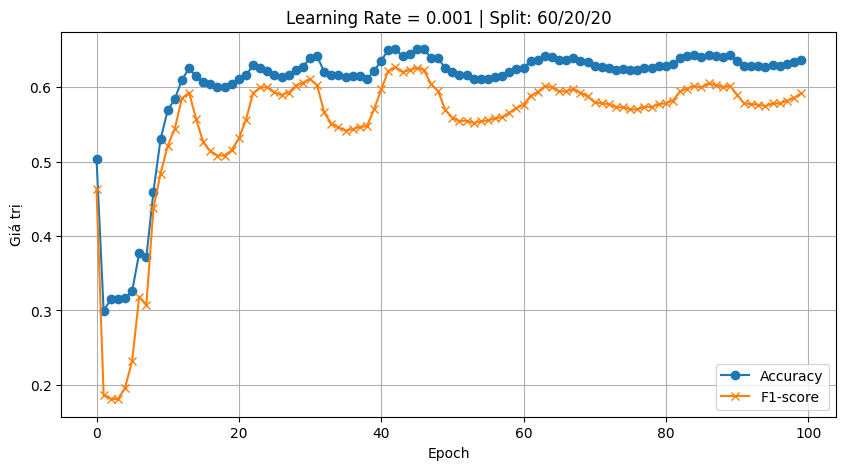

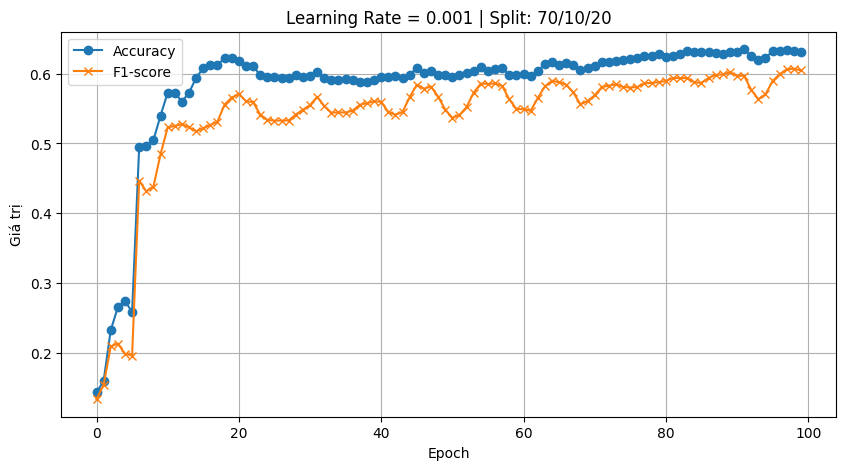

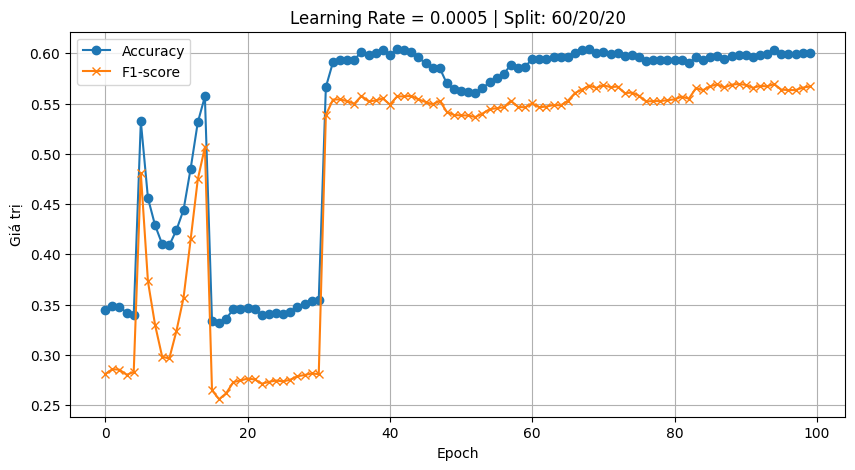

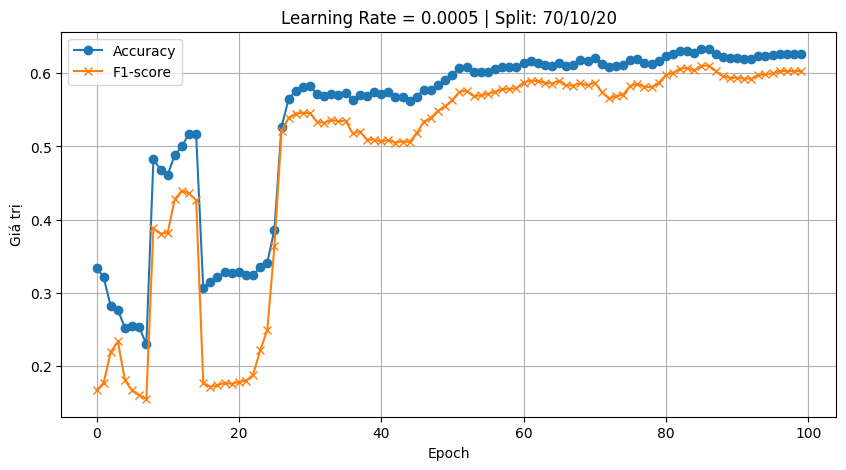

|   Learning Rate | Split    |   Accuracy Cuối |   F1-score Cuối |
|----------------:|:---------|----------------:|----------------:|
|          0.001  | 60/20/20 |          0.6369 |          0.5917 |
|          0.001  | 70/10/20 |          0.6315 |          0.6046 |
|          0.0005 | 60/20/20 |          0.6005 |          0.567  |
|          0.0005 | 70/10/20 |          0.6268 |          0.6028 |


In [12]:
# **Huấn luyện và trực quan hóa mô hình GAT**

import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.nn import GATConv, LayerNorm
from imblearn.over_sampling import SMOTE
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# **Định nghĩa Focal Loss**
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# **Chuyển đổi từ NetworkX sang PyG Data (giả định G đã được định nghĩa)**
def networkx_to_pyg(G, label_attr="damage"):
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()

    features = []
    labels = []
    for node, data in G.nodes(data=True):
        node_features = [data[attr] for attr in data if attr != label_attr]
        features.append(node_features)
        labels.append(data[label_attr])

    X = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    return Data(x=X, edge_index=edge_index, y=y)

# **Mô hình GAT**
class GAT(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_features, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_features, hidden_dim, heads=heads, dropout=0.2)
        self.ln1 = LayerNorm(hidden_dim * heads)

        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=4, dropout=0.2)
        self.ln2 = LayerNorm(hidden_dim * 4)

        self.gat3 = GATConv(hidden_dim * 4, out_features, heads=1, concat=False, dropout=0.2)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.ln1(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat2(x, edge_index)
        x = self.ln2(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat3(x, edge_index)
        return F.log_softmax(x, dim=1)

# **Danh sách cấu hình để thử nghiệm**
lr_list = [0.001, 0.0005]
split_ratios = [(0.6, 0.2, 0.2), (0.7, 0.1, 0.2)]

results = []

for lr in lr_list:
    for train_ratio, val_ratio, test_ratio in split_ratios:

        # Tạo bản sao dữ liệu và xử lý SMOTE
        data = networkx_to_pyg(G)
        X_resampled, y_resampled = SMOTE().fit_resample(data.x.numpy(), data.y.numpy())
        data.x = torch.tensor(X_resampled, dtype=torch.float)
        data.y = torch.tensor(y_resampled, dtype=torch.long)

        # Chia dữ liệu
        num_nodes = data.num_nodes
        idx = list(range(num_nodes))
        train_idx, temp_idx = train_test_split(idx, train_size=train_ratio, random_state=42)
        val_size = val_ratio / (val_ratio + test_ratio)
        val_idx, test_idx = train_test_split(temp_idx, train_size=val_size, random_state=42)

        data.train_mask = torch.tensor(train_idx, dtype=torch.long)
        data.val_mask = torch.tensor(val_idx, dtype=torch.long)
        data.test_mask = torch.tensor(test_idx, dtype=torch.long)

        # Tính trọng số class
        unique, counts = np.unique(data.y.numpy(), return_counts=True)
        class_weights = torch.tensor(1.0 / counts, dtype=torch.float)
        class_weights /= class_weights.sum()
        loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)

        # Huấn luyện mô hình
        model = GAT(in_features=data.x.shape[1], hidden_dim=16, out_features=len(data.y.unique()))
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

        accuracies, f1_scores, epochs = [], [], []
        for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

            model.eval()
            with torch.no_grad():
                logits = model(data.x, data.edge_index)
                pred = logits.argmax(dim=1)

                y_true = data.y[data.test_mask].cpu().numpy()
                y_pred = pred[data.test_mask].cpu().numpy()
                acc = accuracy_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred, average='macro')

                epochs.append(epoch)
                accuracies.append(acc)
                f1_scores.append(f1)

        # Lưu kết quả
        results.append({
            'lr': lr,
            'split': f"{int(train_ratio*100)}/{int(val_ratio*100)}/{int(test_ratio*100)}",
            'epochs': epochs,
            'acc': accuracies,
            'f1': f1_scores
        })

        # Vẽ biểu đồ
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, accuracies, label='Accuracy', marker='o')
        plt.plot(epochs, f1_scores, label='F1-score', marker='x')
        plt.xlabel('Epoch')
        plt.ylabel('Giá trị')
        plt.title(f"Learning Rate = {lr} | Split: {int(train_ratio*100)}/{int(val_ratio*100)}/{int(test_ratio*100)}")
        plt.legend()
        plt.grid(True)
        plt.show()

# **Tạo bảng tổng hợp kết quả cuối cùng**
summary = []
for r in results:
    summary.append({
        'Learning Rate': r['lr'],
        'Split': r['split'],
        'Accuracy Cuối': round(r['acc'][-1], 4),
        'F1-score Cuối': round(r['f1'][-1], 4)
    })

# In bảng
df = pd.DataFrame(summary)
print(df.to_markdown(index=False))

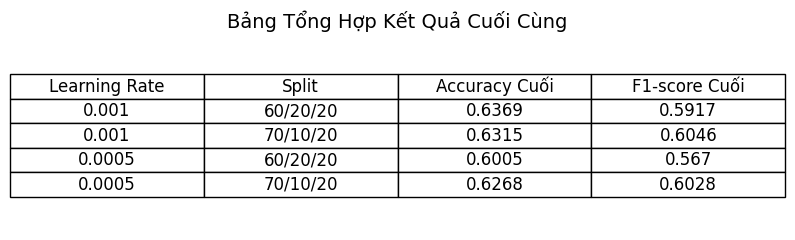

In [13]:
import matplotlib.pyplot as plt

# Vẽ bảng kết quả
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.axis('off')  # Ẩn trục

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

plt.title("Bảng Tổng Hợp Kết Quả Cuối Cùng", fontsize=14, pad=10)
plt.tight_layout()
plt.show()
